## Importing Libraries

In [ ]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import collections
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

## Loading the data

In [ ]:
train_df = pd.read_csv('train.csv',encoding = "ISO-8859-1")
test_df = pd.read_csv('test.csv',encoding = "ISO-8859-1")

In [ ]:
train_df['Sentiment'] = train_df['Sentiment'].astype('category')
print(train_df.dtypes)
train_df.head()

UserName            int64
ScreenName          int64
Location           object
TweetAt            object
OriginalTweet      object
Sentiment        category
dtype: object


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## Exploratory Analysis

In [ ]:
!pip install plot_utils
!pip install jupyterthemes

ERROR: Operation cancelled by user


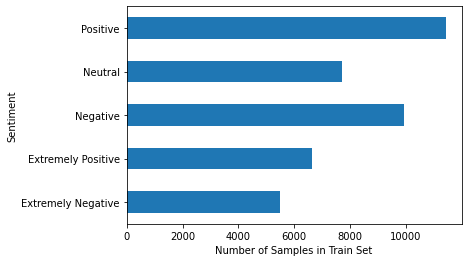

In [ ]:
from jupyterthemes import jtplot
ax = train_df['Sentiment'].value_counts(sort=False).plot(kind='barh');
ax.set_xlabel("Number of Samples in Train Set");
ax.set_ylabel("Sentiment");


### Word Cloud

Extremely Negative

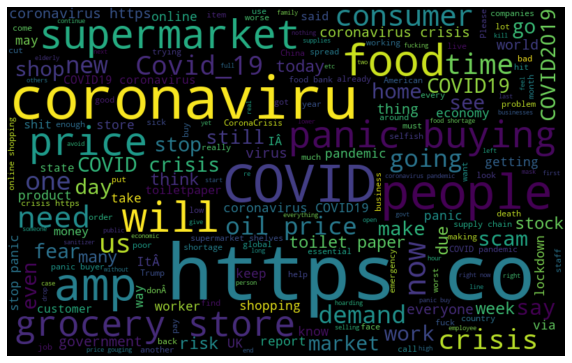

In [ ]:
from wordcloud import WordCloud 
normal_words =' '.join([text for text in train_df['OriginalTweet'][train_df['Sentiment'] == 'Extremely Negative']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

Negative

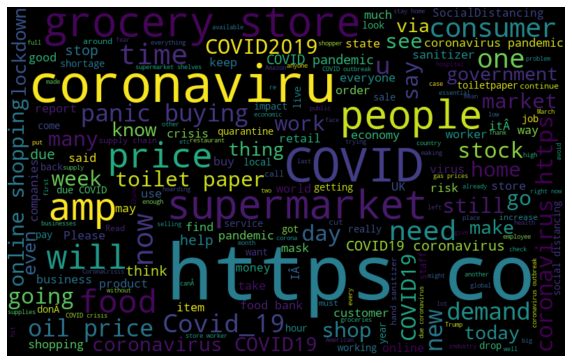

In [ ]:
normal_words =' '.join([text for text in train_df['OriginalTweet'][train_df['Sentiment'] == 'Negative']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

Neutral

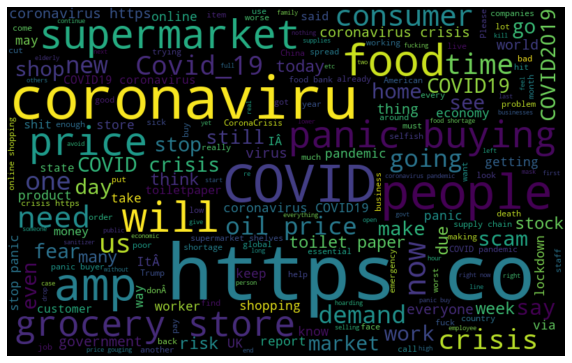

In [ ]:
normal_words =' '.join([text for text in train_df['OriginalTweet'][train_df['Sentiment'] == 'Extremely Negative']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

Positive

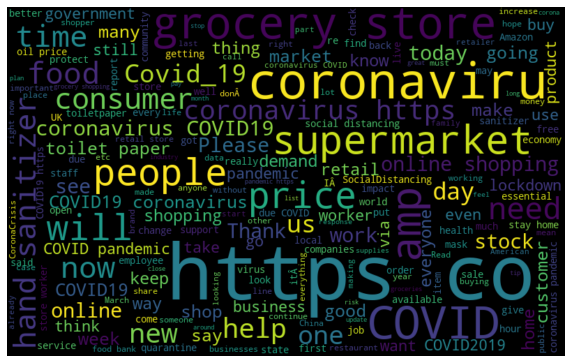

In [ ]:
normal_words =' '.join([text for text in train_df['OriginalTweet'][train_df['Sentiment'] == 'Positive']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

Extremely Positive

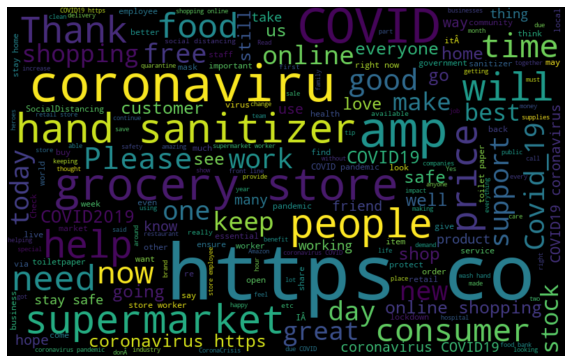

In [ ]:
normal_words =' '.join([text for text in train_df['OriginalTweet'][train_df['Sentiment'] == 'Extremely Positive']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

## Data Pre-processing

### Remove Unwanted

In [ ]:
import re
import string
def remove_unwanted(text):
  text_nopunch = ''
  text_nopunch = re.sub('['+string.punctuation+']',' ',text)
  text_nohash = re.sub(r'#','',text_nopunch)
  text_nohttp = re.sub(r'https?:\/\/S+','',text_nohash)
  return text_nohttp

In [ ]:
train_df['clean_tweets'] = train_df['OriginalTweet'].apply(lambda x : remove_unwanted(x))
test_df['clean_tweets'] = test_df['OriginalTweet'].apply(lambda x : remove_unwanted(x))

### Word Tokenize

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
train_tokens = [word_tokenize(sen) for sen in train_df.clean_tweets]
test_tokens = [word_tokenize(sen) for sen in test_df.clean_tweets]


In [ ]:
def lower_token(tokens): 
    return [word.lower() for word in tokens]    

In [ ]:
train_lower_tokens = [lower_token(token) for token in train_tokens]
test_lower_tokens = [lower_token(token) for token in test_tokens]

### Removing Stop Words

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

In [ ]:
train_filtered_words = [removeStopWords(sen) for sen in train_lower_tokens]
train_df['clean_tweets'] = [' '.join(sen) for sen in train_filtered_words]
train_df['tokens'] = train_filtered_words

test_filtered_words = [removeStopWords(sen) for sen in test_lower_tokens]
test_df['clean_tweets'] = [' '.join(sen) for sen in test_filtered_words]
test_df['tokens'] = test_filtered_words

In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,clean_tweets,tokens
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbie phil gahan chrisitv https co ifz9fan2...,"[menyrbie, phil, gahan, chrisitv, https, co, i..."
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,"[advice, talk, neighbours, family, exchange, p..."
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,"[coronavirus, australia, woolworths, give, eld..."
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please panic enough food ...,"[food, stock, one, empty, please, panic, enoug..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid19 outbreak paranoid...,"[ready, go, supermarket, covid19, outbreak, pa..."


### Word Lemmatization

In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def word_lemmatizer(text):
    lem_text = " ".join([lemmatizer.lemmatize(i) for i in text])
    return lem_text

In [ ]:
train_df['clean_tweets'] = train_df['tokens'].apply(lambda x: word_lemmatizer(x))
test_df['clean_tweets'] = test_df['tokens'].apply(lambda x: word_lemmatizer(x))
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,clean_tweets,tokens
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbie phil gahan chrisitv http co ifz9fan2p...,"[menyrbie, phil, gahan, chrisitv, https, co, i..."
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...,"[advice, talk, neighbours, family, exchange, p..."
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth give elderly d...,"[coronavirus, australia, woolworths, give, eld..."
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please panic enough food ...,"[food, stock, one, empty, please, panic, enoug..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid19 outbreak paranoid...,"[ready, go, supermarket, covid19, outbreak, pa..."
...,...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,airline pilot offering stock supermarket shelf...,"[airline, pilots, offering, stock, supermarket..."
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,response complaint provided citing covid 19 re...,"[response, complaint, provided, citing, covid,..."
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive,know itâs getting tough kameronwilds rationin...,"[know, itâs, getting, tough, kameronwilds, ra..."
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,wrong smell hand sanitizer starting turn coron...,"[wrong, smell, hand, sanitizer, starting, turn..."


In [ ]:
train_df = train_df.drop(['UserName','ScreenName','Location','TweetAt','OriginalTweet'],axis=1)
test_df = test_df.drop(['UserName','ScreenName','Location','TweetAt','OriginalTweet'],axis=1)

In [ ]:
train_df

,Sentiment,clean_tweets,tokens
0,Neutral,menyrbie phil gahan chrisitv http co ifz9fan2p...,"[menyrbie, phil, gahan, chrisitv, https, co, i..."
1,Positive,advice talk neighbour family exchange phone nu...,"[advice, talk, neighbours, family, exchange, p..."
2,Positive,coronavirus australia woolworth give elderly d...,"[coronavirus, australia, woolworths, give, eld..."
3,Positive,food stock one empty please panic enough food ...,"[food, stock, one, empty, please, panic, enoug..."
4,Extremely Negative,ready go supermarket covid19 outbreak paranoid...,"[ready, go, supermarket, covid19, outbreak, pa..."
...,...,...,...
41152,Neutral,airline pilot offering stock supermarket shelf...,"[airline, pilots, offering, stock, supermarket..."
41153,Extremely Negative,response complaint provided citing covid 19 re...,"[response, complaint, provided, citing, covid,..."
41154,Positive,know itâs getting tough kameronwilds rationin...,"[know, itâs, getting, tough, kameronwilds, ra..."
41155,Neutral,wrong smell hand sanitizer starting turn coron...,"[wrong, smell, hand, sanitizer, starting, turn..."


### Encoding the sentiments

In [ ]:
train_df['Sentiment'] = train_df['Sentiment'].astype('category')

In [ ]:
#['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'] = [0,1,2,3,4,5]
train_df['Sentiment'] = train_df['Sentiment'].cat.codes
train_df.head()

,Sentiment,clean_tweets,tokens
0,3,menyrbie phil gahan chrisitv http co ifz9fan2p...,"[menyrbie, phil, gahan, chrisitv, https, co, i..."
1,4,advice talk neighbour family exchange phone nu...,"[advice, talk, neighbours, family, exchange, p..."
2,4,coronavirus australia woolworth give elderly d...,"[coronavirus, australia, woolworths, give, eld..."
3,4,food stock one empty please panic enough food ...,"[food, stock, one, empty, please, panic, enoug..."
4,0,ready go supermarket covid19 outbreak paranoid...,"[ready, go, supermarket, covid19, outbreak, pa..."


### Word Embedding using Word2Vec

In [ ]:
combination = train_df.append(test_df, ignore_index=True) 
combination.shape

(44955, 3)

In [ ]:
tokens = combination['clean_tweets'].apply(lambda x: x.split()) 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim
model_w2v = gensim.models.Word2Vec(
            tokens,
            size=200, # desired no. of features/independent variables
            window=5, 
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1,
            hs = 0,
            negative = 10,
            workers= 32,
            seed = 34
) 

In [ ]:
model_w2v.train(tokens, total_examples= len(combination['clean_tweets']), epochs=20)

(14948024, 18694760)

In [ ]:
len(model_w2v['people'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


200

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

wordvec_arrays = np.zeros((len(tokens), 200)) 
for i in range(len(tokens)):
    wordvec_arrays[i,:] = word_vector(tokens[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(44955, 200)

## Train and Test Data split

In [ ]:
X_train = wordvec_df.iloc[:41157,:]
y_train = train_df['Sentiment']
X_test = wordvec_df.iloc[41157:,:]

In [ ]:
len(X_test)

3798

In [ ]:
from sklearn.model_selection import train_test_split
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train_enc, test_size=0.2, random_state=42)

## K-Means Clustering

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
k_pred = knn.predict(X_val)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, k_pred)

array([[ 774,   40,  139,   23,   80],
       [  72,  927,   77,   37,  217],
       [ 367,  185, 1133,   91,  230],
       [ 136,  121,  274,  814,  208],
       [ 188,  389,  364,  191, 1155]])

In [ ]:
from sklearn.metrics import classification_report
classification_report(y_val, k_pred)

'              precision    recall  f1-score   support\n\n           0       0.50      0.73      0.60      1056\n           1       0.56      0.70      0.62      1330\n           2       0.57      0.56      0.57      2006\n           3       0.70      0.52      0.60      1553\n           4       0.61      0.51      0.55      2287\n\n    accuracy                           0.58      8232\n   macro avg       0.59      0.60      0.59      8232\nweighted avg       0.60      0.58      0.58      8232\n'

In [ ]:
k_pred = knn.predict(X_test)

In [ ]:
k_pred[:10]

array([2, 1, 1, 0, 0, 2, 4, 3, 0, 4], dtype=int8)

In [ ]:
y_pred = []
cnt = 1
for x in k_pred:
  if (x == 'Extremely Negative'):
    y_pred.append([cnt,'Extremely Negative'])
    cnt+=1
  elif (x == 'Extremely Positive'):
    y_pred.append([cnt,'Extremely Positive'])
    cnt+=1
  elif (x == 'Negative'):
    y_pred.append([cnt,'Negative'])
    cnt+=1
  elif (x == 'Neutral'):
    y_pred.append([cnt,'Neutral'])
    cnt+=1
  elif(x == 'Positive'):
    y_pred.append([cnt,'Positive'])
    cnt+=1


In [ ]:
import csv
# field names 
fields = ['UserName','Sentiment'] 
with open('183_knn.csv', 'w') as f: 
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(y_pred)


## Decison Tree Classifier

In [ ]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
model.fit(X_train_new, y_train_new)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
d_pred = model.predict(X_val)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, d_pred)

array([[288, 132, 288, 137, 211],
       [129, 375, 230, 181, 415],
       [307, 253, 593, 326, 527],
       [141, 178, 340, 479, 415],
       [275, 396, 499, 389, 728]])

In [ ]:
from sklearn.metrics import classification_report
classification_report(y_val, d_pred)

'              precision    recall  f1-score   support\n\n           0       0.25      0.27      0.26      1056\n           1       0.28      0.28      0.28      1330\n           2       0.30      0.30      0.30      2006\n           3       0.32      0.31      0.31      1553\n           4       0.32      0.32      0.32      2287\n\n    accuracy                           0.30      8232\n   macro avg       0.29      0.30      0.29      8232\nweighted avg       0.30      0.30      0.30      8232\n'

In [ ]:
d_pred = model.predict(X_test)

In [ ]:
d_pred[:10]

array([2, 1, 4, 2, 0, 2, 1, 2, 1, 0], dtype=int8)

## Random Forest Classification

In [ ]:
# field names 
fields = ['UserName','Sentiment'] 
with open('183_decision_tree.csv', 'w') as f: 
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(y_pred)

In [ ]:
train_df['Sentiment'] = train_df['Sentiment'].astype('category')
train_df['Sentiment'] = train_df['Sentiment'].cat.codes


In [ ]:
y_train_enc = train_df['Sentiment']
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 5, random_state = 42)
# Train the model on training data
rf.fit(X_train_new, y_train_new);

In [ ]:
predictions = rf.predict(X_val)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, predictions)